# DACON 병원 개/폐업 분류 예측 경진대회
[DACON 병원 개/폐업 분류 예측 경진대회](https://dacon.io/competitions/official/9565/overview/description)

## Base EDA and Preprocessing

### 사용 라이브러리

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
def eval_CM(y_test, y_pred=None, pred_prob=None, show_cm=0):
    confusion = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pred_prob)
    if show_cm:
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}\nROC_AUC: {roc_auc:.4f}")
    else:
        print(confusion)
        print(f"정확도: {acc:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nF1: {f1:.4f}\nROC_AUC: {roc_auc:.4f}")
    return confusion, acc, precision, recall, f1, roc_auc

def reg_score(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    MAE = np.mean( np.abs((y_true - y_pred) / y_true) )
    NMAE = mean_absolute_error(y_true, y_pred)/ np.mean( np.abs(y_true) )
    MAPE = np.mean( np.abs((y_true - y_pred) / y_true) ) *100
    R2 = r2_score(y_true, y_pred)
    
    print(f"MSE: {np.round(MSE, 3)}\nRMSE: {np.round(RMSE, 3)}\nMAE: {np.round(MAE, 3)}\nNMAE: {np.round(NMAE, 3)}\nMAPE: {np.round(MAPE, 3)}\nR2: {np.round(R2, 3)}")

### Data Load

In [3]:
import glob

path = glob.glob("data/*")
path

['data\\submission_sample.csv', 'data\\test.csv', 'data\\train.csv']

In [4]:
train, test = pd.read_csv(path[2], encoding="cp949"), pd.read_csv(path[1], encoding="cp949")

train.shape, test.shape

((301, 58), (127, 58))

### EDA 및 전처리
#### 기본 정보

In [5]:
display(train.head())
display(test.head())

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.0,300.0,general_hospital,6.682486e+10,0.000000e+00,6.565709e+10,...,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693,693,same
1,5,NaN,jeju,149,20160309.0,44.0,hospital,3.495758e+10,0.000000e+00,3.259270e+10,...,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379,371,same
2,6,NaN,jeonnam,103,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,...,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.0,363.0,general_hospital,0.000000e+00,0.000000e+00,0.000000e+00,...,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760,760,same
4,10,NaN,jeonbuk,26,20040604.0,213.0,general_hospital,5.037025e+10,0.000000e+00,4.855803e+10,...,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437,385,same


* inst_id - 각 파일에서의 병원 고유 번호  
* OC – 영업(1)/폐업(0) 분류  
* sido – 병원의 광역 지역 정보  
* sgg – 병원의 시군구 자료  
* openDate – 병원 설립일  
* bedCount - 병원이 갖추고 있는 병상의 수  
* instkind – 병원, 의원, 요양병원, 한의원, 종합병원 등 병원의 종류  
  * 종합병원 : 입원환자 100명 이상 수용 가능
  * 병원 : 입원 환자 30명 이상 100명 미만 수용 가능
  * 의원 : 입원 환자 30명 이하 수용 가능
  * 한방 병원(한의원) : 침술과 한약으로 치료하는 의료 기관
* revenue1 – 매출액, 2017(회계년도)년 데이터를 의미함
* salescost1 – 매출원가, 2017(회계년도)년 데이터를 의미함
* sga1 - 판매비와 관리비, 2017(회계년도)년 데이터를 의미함
* salary1 – 급여, 2017(회계년도)년 데이터를 의미함
* noi1 – 영업외수익, 2017(회계년도)년 데이터를 의미함
* noe1 – 영업외비용, 2017(회계년도)년 데이터를 의미함
* Interest1 – 이자비용, 2017(회계년도)년 데이터를 의미함
* ctax1 – 법인세비용, 2017(회계년도)년 데이터를 의미함
* Profit1 – 당기순이익, 2017(회계년도)년 데이터를 의미함
* liquidAsset1 – 유동자산, 2017(회계년도)년 데이터를 의미함
* quickAsset1 – 당좌자산, 2017(회계년도)년 데이터를 의미함
* receivableS1 - 미수금(단기), 2017(회계년도)년 데이터를 의미함
* inventoryAsset1 – 재고자산, 2017(회계년도)년 데이터를 의미함
* nonCAsset1 – 비유동자산, 2017(회계년도)년 데이터를 의미함
* tanAsset1 – 유형자산, 2017(회계년도)년 데이터를 의미함
* OnonCAsset1 - 기타 비유동자산, 2017(회계년도)년 데이터를 의미함
* receivableL1 – 장기미수금, 2017(회계년도)년 데이터를 의미함
* debt1 – 부채총계, 2017(회계년도)년 데이터를 의미함
* liquidLiabilities1 – 유동부채, 2017(회계년도)년 데이터를 의미함
* shortLoan1 – 단기차입금, 2017(회계년도)년 데이터를 의미함
* NCLiabilities1 – 비유동부채, 2017(회계년도)년 데이터를 의미함
* longLoan1 – 장기차입금, 2017(회계년도)년 데이터를 의미함
* netAsset1 – 순자산총계, 2017(회계년도)년 데이터를 의미함
* surplus1 – 이익잉여금, 2017(회계년도)년 데이터를 의미함
* revenue2 – 매출액, 2016(회계년도)년 데이터를 의미함
* salescost2 – 매출원가, 2016(회계년도)년 데이터를 의미함
* sga2 - 판매비와 관리비, 2016(회계년도)년 데이터를 의미함
* salary2 – 급여, 2016(회계년도)년 데이터를 의미함
* noi2 – 영업외수익, 2016(회계년도)년 데이터를 의미함
* noe2 – 영업외비용, 2016(회계년도)년 데이터를 의미함
* interest2 – 이자비용, 2016(회계년도)년 데이터를 의미함
* ctax2 – 법인세비용, 2016(회계년도)년 데이터를 의미함
* profit2 – 당기순이익, 2016(회계년도)년 데이터를 의미함
* liquidAsset2 – 유동자산, 2016(회계년도)년 데이터를 의미함
* quickAsset2 – 당좌자산, 2016(회계년도)년 데이터를 의미함
* receivableS2 - 미수금(단기), 2016(회계년도)년 데이터를 의미함
* inventoryAsset2 – 재고자산, 2016(회계년도)년 데이터를 의미함
* nonCAsset2 – 비유동자산, 2016(회계년도)년 데이터를 의미함
* tanAsset2 – 유형자산, 2016(회계년도)년 데이터를 의미함
* OnonCAsset2 - 기타 비유동자산, 2016(회계년도)년 데이터를 의미함
* receivableL2 – 장기미수금, 2016(회계년도)년 데이터를 의미함
* Debt2 – 부채총계, 2016(회계년도)년 데이터를 의미함
* liquidLiabilities2 – 유동부채, 2016(회계년도)년 데이터를 의미함
* shortLoan2 – 단기차입금, 2016(회계년도)년 데이터를 의미함
* NCLiabilities2 – 비유동부채, 2016(회계년도)년 데이터를 의미함
* longLoan2 – 장기차입금, 2016(회계년도)년 데이터를 의미함
* netAsset2 – 순자산총계, 2016(회계년도)년 데이터를 의미함
* surplus2 – 이익잉여금, 2016(회계년도)년 데이터를 의미함
* employee1 – 고용한 총 직원의 수, 2017(회계년도)년 데이터를 의미함
* employee2 – 고용한 총 직원의 수, 2016(회계년도)년 데이터를 의미함
* ownerChange – 대표자의 변동 

컬럼명 패턴이, 1이 붙으면 2017년 데이터, 2가 붙으면 2016년 데이터임

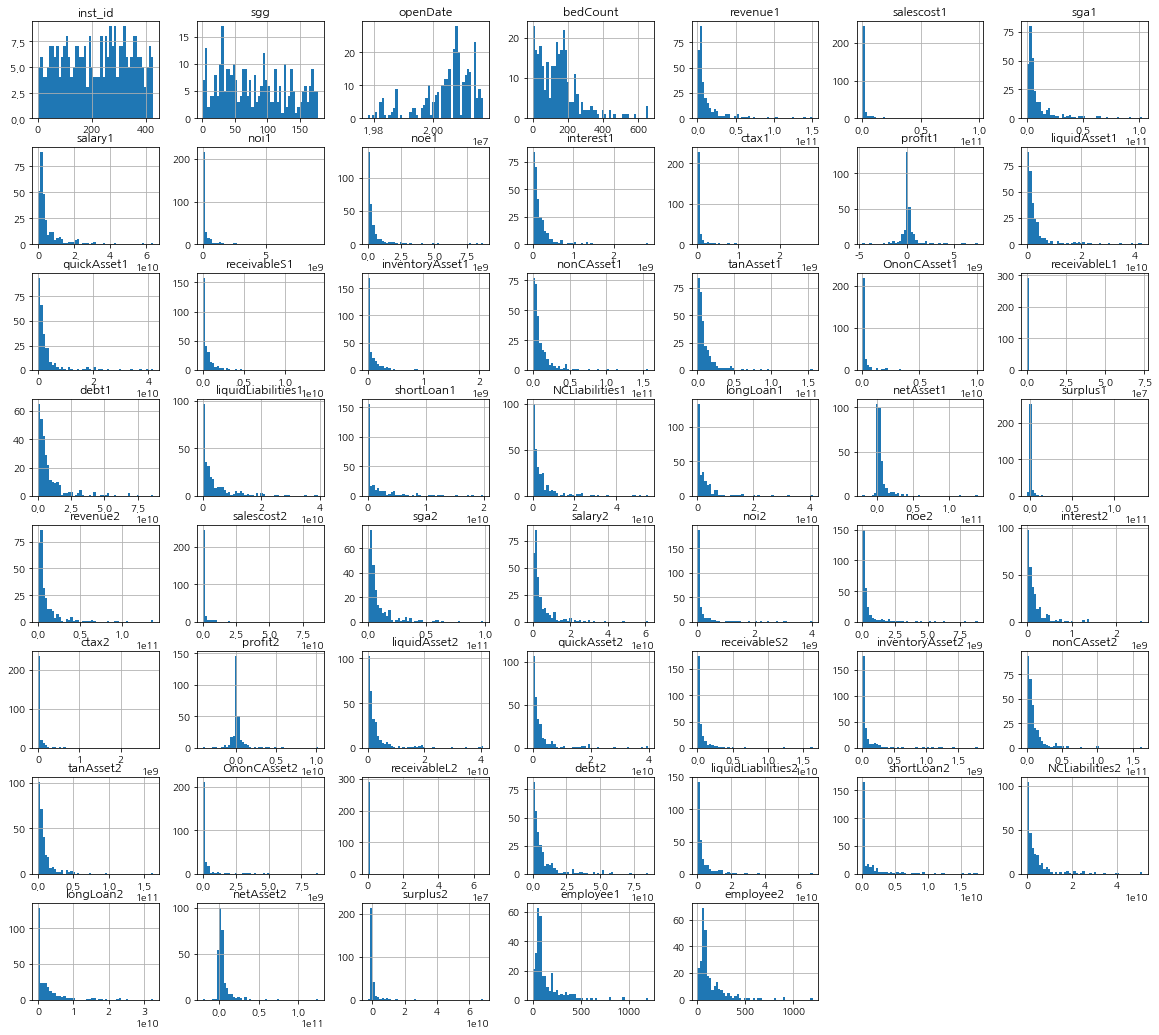

In [6]:
_ = train.hist(bins=50, figsize=(20, 18))

#### 결측치 확인 및 이상치 처리

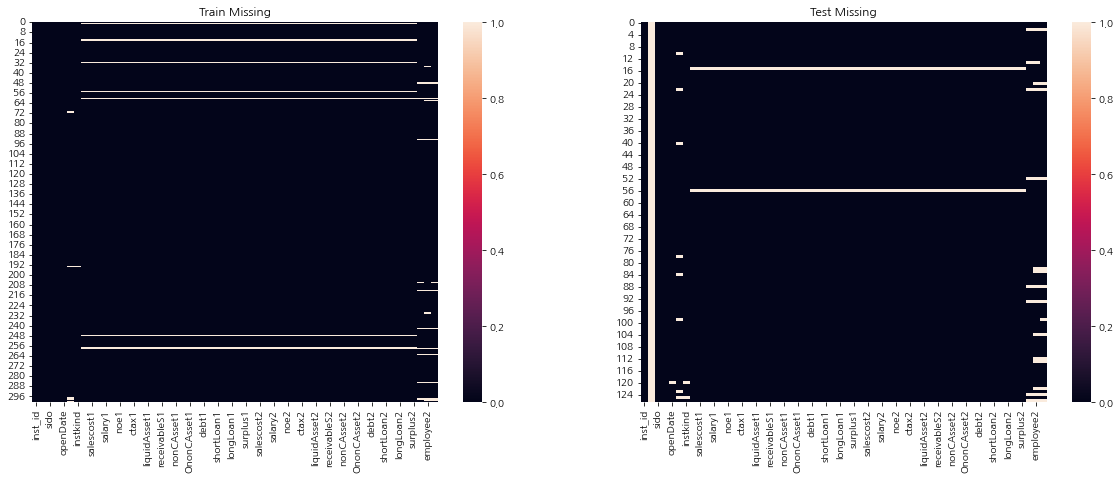

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
sns.heatmap(train.isnull(), ax=ax[0]).set_title("Train Missing")
sns.heatmap(test.isnull(), ax=ax[1]).set_title("Test Missing")
plt.show()

##### OC - 영업/폐업 분류

In [9]:
train["OC"].isnull().sum(), test["OC"].isnull().sum()

(0, 127)

`OC`는 예측해야하는 값이므로 test에는 결측치가 존재하는 것이 당연함

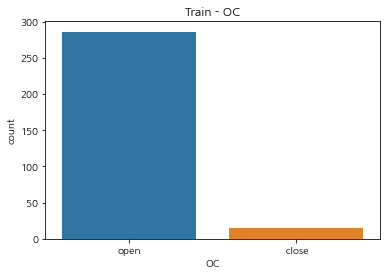

In [10]:
_ = sns.countplot(x=train["OC"]).set_title("Train - OC")

In [11]:
train["OC"].value_counts(normalize=True)*100

open      95.016611
 close     4.983389
Name: OC, dtype: float64

오버 샘플링을 고려해 볼 만함

##### sido - 광역 지역 정보

In [12]:
train["sido"].isnull().sum(), test["sido"].isnull().sum()

(0, 0)

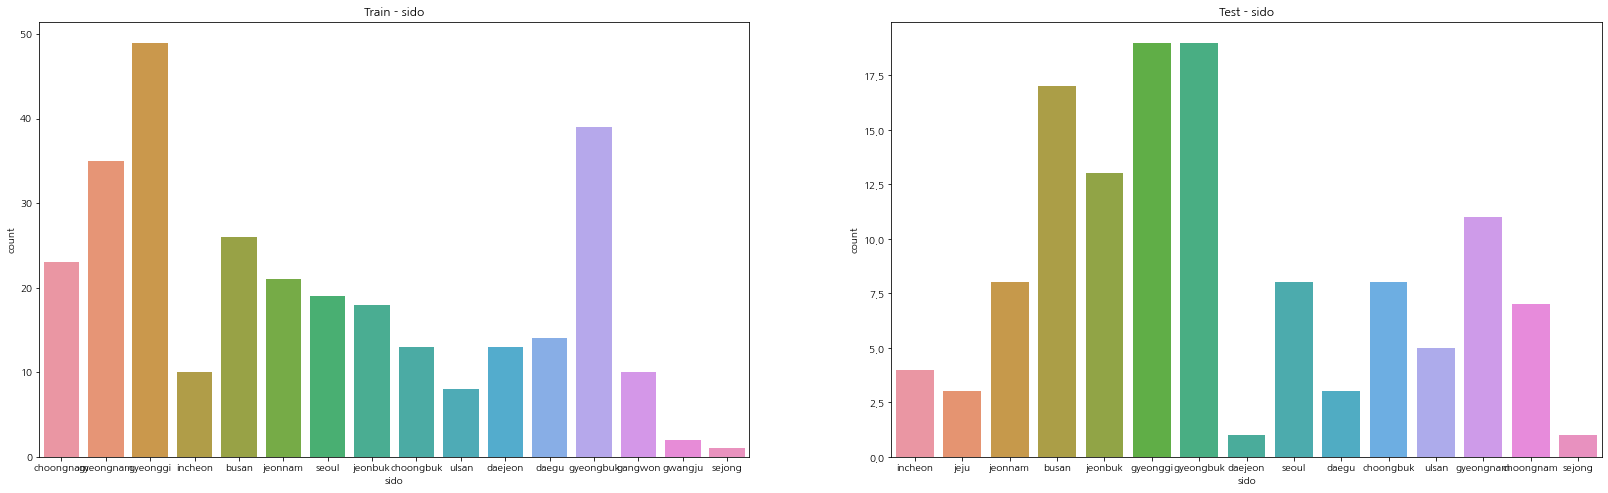

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.countplot(data=train, x="sido", ax=ax[0]).set_title("Train - sido")
sns.countplot(data=test, x="sido", ax=ax[1]).set_title("Test - sido")
plt.show()

광역 지역을 좀 더 일반화 시키는 것이 좋을꺼 같다는 생각을 함

In [14]:
set(train["sido"].value_counts().index) - set(test["sido"].value_counts().index)

{'gangwon', 'gwangju'}

In [15]:
train[train["sido"]=='gangwon'].shape, test[test["sido"]=='gangwon'].shape

((10, 58), (0, 58))

In [16]:
train[train["sido"]=='gwangju'].shape, test[test["sido"]=='gwangju'].shape

((2, 58), (0, 58))

강원도와 광주의 경우 `train`에는 존재하지만 `test`에는 존재하지 않음

In [17]:
set(test["sido"].value_counts().index) - set(train["sido"].value_counts().index)

{'jeju'}

In [18]:
train[train["sido"]=='jeju'].shape, test[test["sido"]=='jeju'].shape

((0, 58), (3, 58))

반대로, 제주도는 `test`에는 존재하지만 `train`에는 존재하지 않음

먼저, 북과 남을 합쳐 도로 만들어 개수를 줄여봄

In [19]:
# ~남 ~북을 제거, ex. 충남 -> 충 / 충북 -> 충
train["sido"] = train["sido"].str.replace("nam|buk", "")
test["sido"] = test["sido"].str.replace("nam|buk", "")
# 인천과 경기를 묶어줌
train["sido"] = train["sido"].str.replace("gyeonggi|incheon", "gyeon-in")
test["sido"] = test["sido"].str.replace("gyeonggi|incheon", "gyeon-in")

In [20]:
sido_list = set(train["sido"].value_counts().index) | set(test["sido"].value_counts().index)
len(sido_list)

13

특별시나 광역시도 그냥 도로 편입 시킬까하다 진행하지 않음  
보기 좋게 한글명으로 변환

In [21]:
train["sido"] = train["sido"].replace({"busan": "부산",
                                        "choong": "충청도",
                                        "daegu": "대구",
                                        "daejeon": "대전",
                                        "gangwon": "강원도",
                                        "gwangju": "광주",
                                        "gyeon-in": "경인",
                                        "gyeong": "경상도",
                                        "jeju": "제주도",
                                        "jeon": "전라도",
                                        "sejong": "세종",
                                        "seoul": "서울",
                                        "ulsan": "울산"})
test["sido"] = test["sido"].replace({"busan": "부산",
                                        "choong": "충청도",
                                        "daegu": "대구",
                                        "daejeon": "대전",
                                        "gangwon": "강원도",
                                        "gwangju": "광주",
                                        "gyeon-in": "경인",
                                        "gyeong": "경상도",
                                        "jeju": "제주도",
                                        "jeon": "전라도",
                                        "sejong": "세종",
                                        "seoul": "서울",
                                        "ulsan": "울산"})

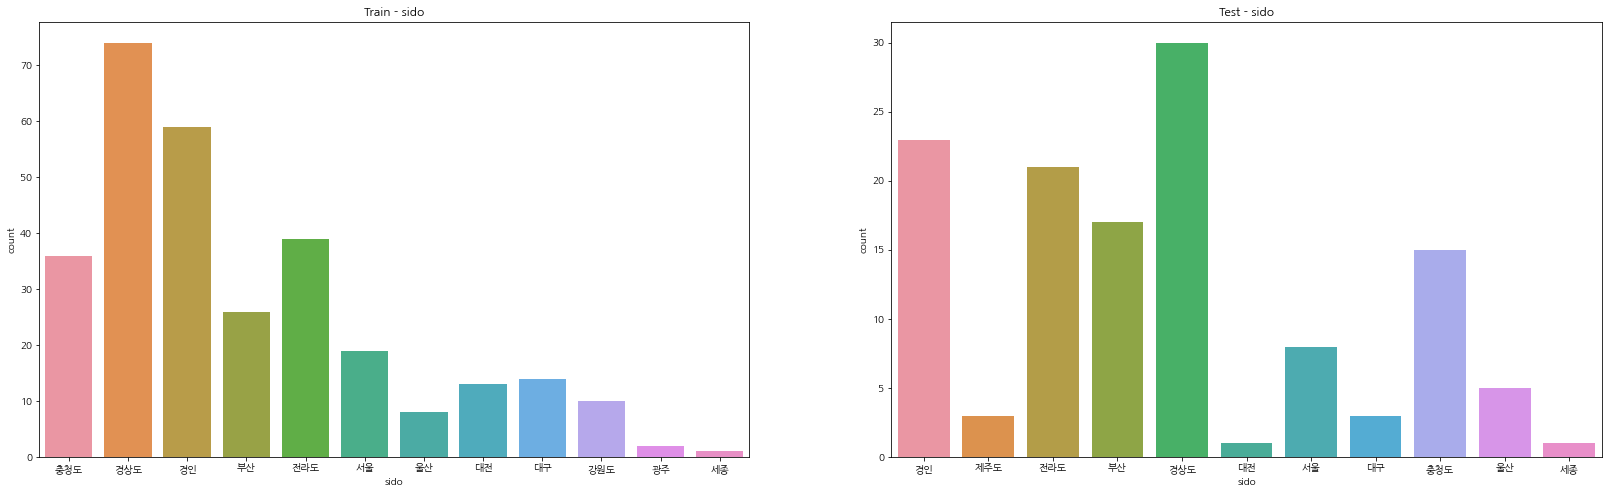

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
sns.countplot(data=train, x="sido", ax=ax[0]).set_title("Train - sido")
sns.countplot(data=test, x="sido", ax=ax[1]).set_title("Test - sido")
plt.show()

##### sgg - 시군구 자료

In [23]:
train["sgg"].isnull().sum(), test["sgg"].isnull().sum()

(0, 0)

##### openDate - 병원 설립일
데이터 타입을 `datetime`으로 변환하고 `년/월`만 남김

In [24]:
train["openDate"].isnull().sum(), test["openDate"].isnull().sum()

(0, 1)

In [25]:
test["openDate"] = test["openDate"].fillna(0)

In [26]:
train["openDate"] = pd.to_datetime(train["openDate"].astype("str"), format="%Y/%m/%d")
test["openDate"] = pd.to_datetime(test["openDate"].astype("int").astype("str"), format="%Y/%m/%d", errors="coerce")

In [27]:
train["open_year"] = train["openDate"].dt.year
train["open_month"] = train["openDate"].dt.month
test["open_year"] = test["openDate"].dt.year
test["open_month"] = test["openDate"].dt.month

train.drop(columns="openDate", axis=1, inplace=True)
test.drop(columns="openDate", axis=1, inplace=True)

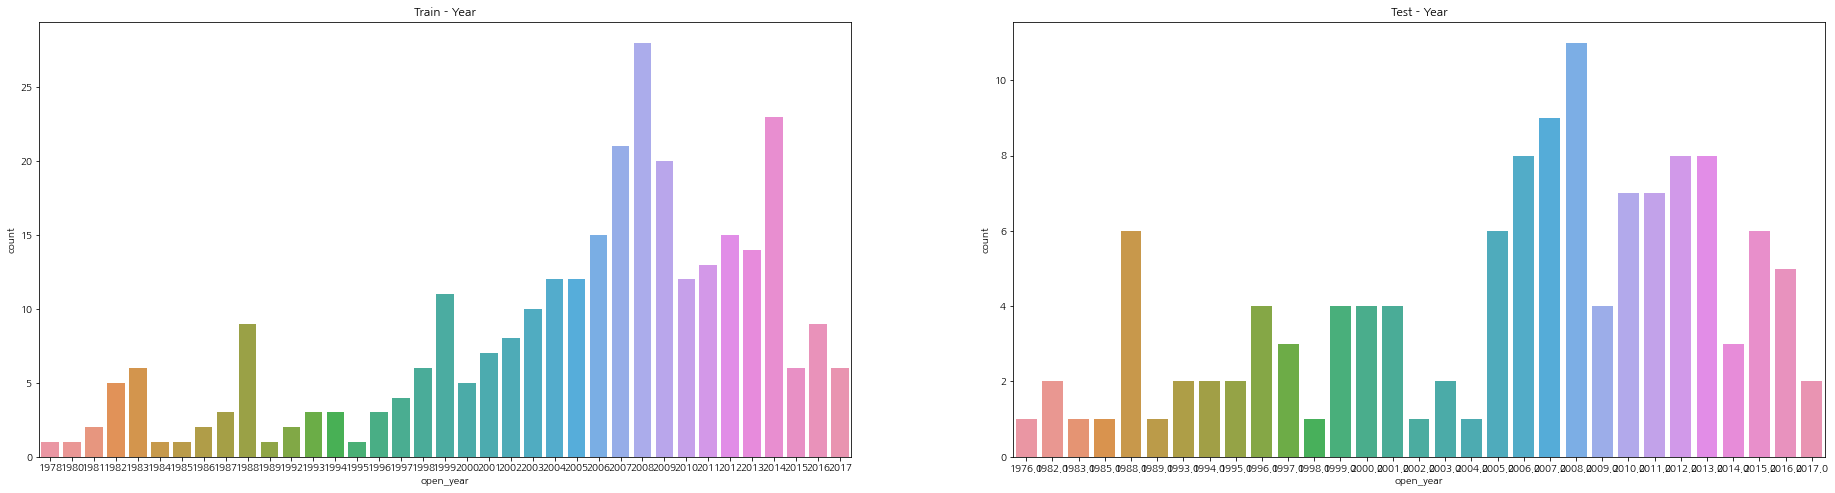

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(32, 8))
sns.countplot(data=train, x="open_year", ax=ax[0]).set_title("Train - Year")
sns.countplot(data=test, x="open_year", ax=ax[1]).set_title("Test - Year")
plt.show()

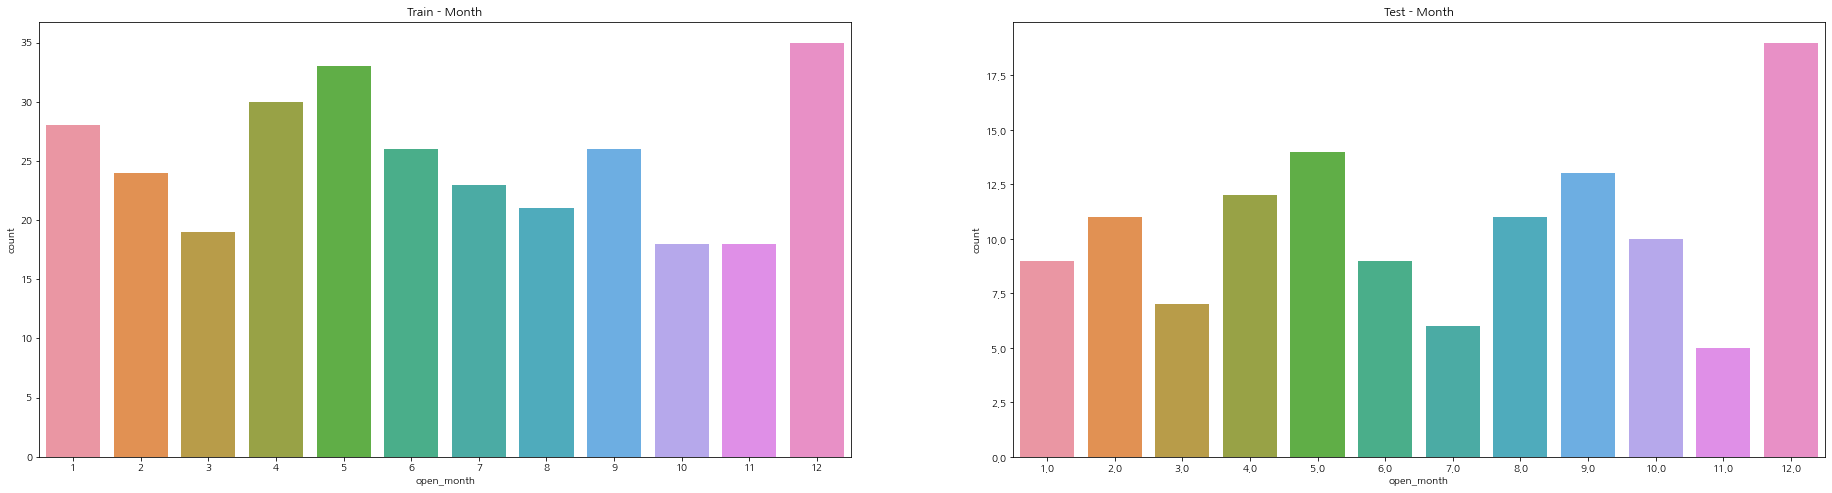

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(32, 8))
sns.countplot(data=train, x="open_month", ax=ax[0]).set_title("Train - Month")
sns.countplot(data=test, x="open_month", ax=ax[1]).set_title("Test - Month")
plt.show()

##### bedCount - 병원이 갖추고 있는 병상의 수

In [30]:
train["bedCount"].isnull().sum(), test["bedCount"].isnull().sum()

(5, 8)

결측치는 0으로 처리하는 방법도 있으나, 병원의 종류를 나타내는 `instkind`와 관련이 있을것이라고 생각함  
침상의 수를 구간별로 나누고, 없는 부분도 정보로써 활용해볼 예정

의원은 30병상 미만의 의료기관입니다.  
30~100병상 미만을 '병원'이라고 합니다.  
100~500병상 미만이면서 일정 수의 진료과목이 있고 진료과목마다 전문의를 두는 등의 특정 조건을 충족하면 종합병원으로 분류  
500병상 이상이면서 특정 조건을 충족하면 상급종합병원 자격이 됨

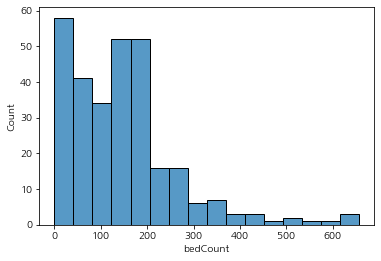

In [31]:
_ = sns.histplot(data=train, x="bedCount")

In [32]:
def bedCount2band(num):
    if num<30: return "의원"
    elif 30<=num<100: return "병원"
    elif 100<=num<500: return "종합병원"
    elif num>=500: return "상급종합병원"

In [33]:
train["bedCount"] = train["bedCount"].apply(bedCount2band)
test["bedCount"] = test["bedCount"].apply(bedCount2band)

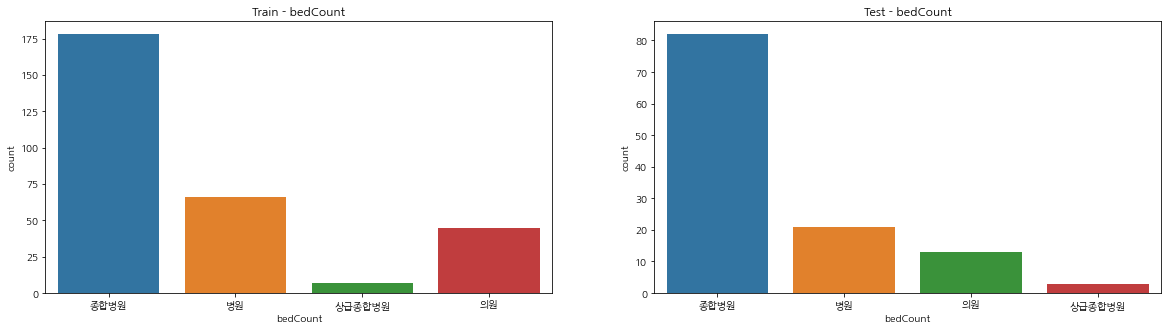

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(data=train, x="bedCount", ax=ax[0]).set_title("Train - bedCount")
sns.countplot(data=test, x="bedCount", ax=ax[1]).set_title("Test - bedCount")
plt.show()

##### instkind - 병원의 종류

In [36]:
train["instkind"].isnull().sum(), test["instkind"].isnull().sum()

(1, 2)

In [40]:
display(train[train["instkind"].isnull()])
display(test[test["instkind"].isnull()])

,inst_id,OC,sido,sgg,bedCount,instkind,revenue1,salescost1,sga1,salary1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,open_year,open_month
193,281,close,경인,12,None,NaN,305438818.0,22416139.0,467475340.0,254868810.0,...,0.0,0.0,0.0,0.0,0.0,15.0,15.0,change,2012,12


,inst_id,OC,sido,sgg,bedCount,instkind,revenue1,salescost1,sga1,salary1,...,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,open_year,open_month
120,413,NaN,경인,168,병원,NaN,5.583625e+08,7.443415e+07,5.482900e+08,2.826852e+08,...,0.0,0.000000e+00,0.000000e+00,0.0,0.0,21,21,same,NaN,NaN
125,430,NaN,제주도,76,None,NaN,4.892710e+10,4.157148e+10,4.721485e+09,1.514547e+09,...,0.0,2.871805e+10,2.563120e+10,-205062936.0,0.0,363,343,same,2001.0,2.0


In [41]:
train["instkind"].unique()

array(['nursing_hospital', 'general_hospital', 'hospital',
       'traditional_clinic', 'clinic', 'traditional_hospital',
       'dental_clinic', nan], dtype=object)

##### float형 변수
결측치는 `-999`로 대체

In [124]:
same_col = ["inst_id", "OC", "sido", "sgg", "bedCount", "instkind"]
in_col_train = train.columns.tolist()[6:]
in_col_test = test.columns.tolist()[6:]

In [125]:
temp = train[in_col_train].replace(0, -999)
temp = temp.fillna(-999)

pre_train = pd.concat([train[same_col], temp], axis=1)

In [130]:
temp = test[in_col_test].replace(0, -999)
temp = temp.fillna(-999)

pre_test = pd.concat([test[same_col], temp], axis=1)

`ownerChange`는 `nan`유지

In [134]:
pre_train["ownerChange"] = pre_train["ownerChange"].replace(-999, np.nan)
pre_test["ownerChange"] = pre_test["ownerChange"].replace(-999, np.nan)

In [168]:
pre_train.to_csv("data/pre_train.csv", index=False)
pre_test.to_csv("data/pre_test.csv", index=False)